This analysis attempts to model the causal relationships between excercise and Parkinsons disease progression metrics from the SPARX clinical trial. The goal of this analysis is to develop a naive model from which further improvements can be made. This analysis relies on the causalnex package which contains methods for causal inference with bayesian networks. Although, the MDS UPDRS ME score is used as the endpoint in this analysis, a number of endpoints could be used in its place. 

This notebook requires the dbsas.pgsql databse connection (See README.md).

Start by setting up the python environment.

In [1]:
!pip install psycopg2
!pip install causalnex
!pip install pandas
!pip install numpy==1.17
!pip install matplotlib

# db module to connect to postgres db with all tables, instructions in README.md
from db import connect
conn = connect()

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# from imports
from collections import Counter


# causalnex
from causalnex.plots import plot_structure
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


     |████████████████████████████████| 15.0MB 2.2MB/s eta 0:00:01
  Found existing installation: numpy 1.17.2
    Uninstalling numpy-1.17.2:
      Successfully uninstalled numpy-1.17.2


First, a quick sanity check to make sure endpoints match with reported endpoints.

In [2]:
mdsupdrs = pd.read_sql('SELECT t1.idnum, t1.timepoint, t1.mds_part1, t1.mds_part2, t1.mds_part3, t1.mds_part4, t2.typerandomization1 \
FROM mdsupdrs AS t1 LEFT JOIN participant AS t2 ON t1.idnum = t2.idnum', conn)


# baseline (timepoint 4) and 6 months (timepoint 11)
data4 = mdsupdrs[(mdsupdrs['timepoint'] == 4)]
data11 = mdsupdrs[(mdsupdrs['timepoint'] == 11)]

df = data11.merge(data4, on=('idnum'), suffixes=('_6m', '_base'))

hi = df[df['typerandomization1_base'] == 1]
med = df[df['typerandomization1_base'] == 2]
con = df[df['typerandomization1_base'] == 3]

print("MDS-UPDRS mean subscores")
print(
    "Part 1 - Mean High Intensity 6 months: ",
    np.mean(hi.mds_part1_6m - hi.mds_part1_base)
)
print(
    "Part 2 - Mean High Intensity 6 months: ",
    np.mean(hi.mds_part2_6m - hi.mds_part2_base)
)
print(
    "Part 1 - Mean Moderate Intensity 6 months: ",
    np.mean(med.mds_part1_6m - med.mds_part1_base)
)
print(
    "Part 2 - Mean Moderate Intensity 6 months: ",
    np.mean(med.mds_part2_6m - med.mds_part2_base)
)
print(
    "Part 1 - Mean Control 6 months: ",
    np.mean(con.mds_part1_6m - con.mds_part1_base)
)
print(
    "Part 2 - Mean Control 6 months: ",
    np.mean(con.mds_part2_6m - con.mds_part2_base)
)

MDS-UPDRS mean subscores
Part 1 - Mean High Intensity 6 months:  1.0263157894736843
Part 2 - Mean High Intensity 6 months:  1.5
Part 1 - Mean Moderate Intensity 6 months:  -0.11904761904761904
Part 2 - Mean Moderate Intensity 6 months:  0.7619047619047619
Part 1 - Mean Control 6 months:  0.6216216216216216
Part 2 - Mean Control 6 months:  0.8648648648648649


MDS-UPDRS mean subscores

Part 1 - Mean High Intensity 6 months:  1.0263157894736843

Part 2 - Mean High Intensity 6 months:  1.5

Part 1 - Mean Moderate Intensity 6 months:  -0.11904761904761904

Part 2 - Mean Moderate Intensity 6 months:  0.7619047619047619

Part 1 - Mean Control 6 months:  0.6216216216216216

Part 2 - Mean Control 6 months:  0.8648648648648649

These values are approximately what is reported in the study publication, so it seem sensible to proceed. However, it is a little concerning that these values are not precisely the same and that could be investigated further.

The SPARX study design is a randomized controlled trial with 2 interventions;  moderate-intensity and high-intensity endurance exercise with a control group (no excercise). The primary endpoint is taken at 6 months with participants encouraged to continue to excercise an additonal 6 months.

Hence, a naive bayesian network to model this study for the first 6 months could take the following structure:

/Users/kyle/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/kyle/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


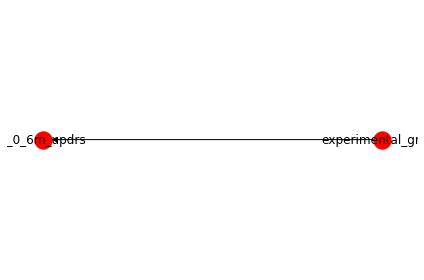

In [3]:
sm = StructureModel()
sm.add_edges_from([
    ('experimental_group','d_0_6m_updrs')
])
_ = plot_structure(sm)

Where d_0_6m_updrs is the difference between the 6 month UPDRS score and the base line UPDRS score and the experimental group is one of high intensity, moderate intensity, or control.

Additionally, we may want to include the 12 month endpoint. Also, including data for the baseline, 3 month, and 6 month endpoint may be more informative. For example, subjects may have different rates of disease progression or slowing based on the baseline. There may also be differences in the individuals response size to the treatment. 

A model could be made with timepoint -> score and experimental_group -> score, but this would not give us the conditional probalility distributions for individuals with different rates of disease progression/slowing. Therefore, it seem appropriate to model a given enpoint as its difference from its baseline.

A network to model this could take the following form:

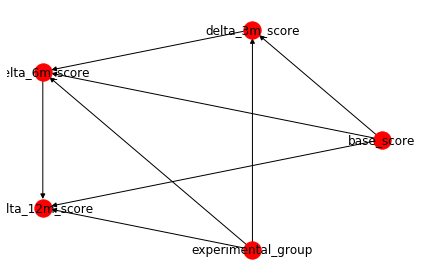

In [4]:
sm = StructureModel()
sm.add_edges_from([
    ('base_score', 'delta_3m_score'),
    ('base_score','delta_6m_score'),
    ('base_score', 'delta_12m_score'),
    ('experimental_group','delta_3m_score'),
    ('experimental_group','delta_6m_score'),
    ('experimental_group', 'delta_12m_score'),
    ('delta_3m_score','delta_6m_score'),
    ('delta_6m_score','delta_12m_score')
])
_ = plot_structure(sm)

The base score should not provide information for the experimental group given the randomization, though this could be investigated further.

Though this model is still very naive it provides a point of comparison comparison to aid model refinement.

Now its time to get the relevant data for this model.

In a more detailed analysis, it would be wise to QC the data at this point.

In [5]:
# requires connection to pdsas postgresql databse
mdsupdrs = pd.read_sql('SELECT t1.idnum, t1.timepoint, t1.mds_part3, t2.typerandomization1, t2.typerandomization2 \
FROM mdsupdrs AS t1 LEFT JOIN participant AS t2 ON t1.idnum = t2.idnum', conn)


In [6]:
# some timepoints dont have values
tmp = mdsupdrs[(mdsupdrs['timepoint'] != 0)]
for idnum in tmp['idnum'].unique():
    if len(tmp[(tmp['idnum']==idnum)].timepoint.unique()) != 4:
        print(idnum, tmp[(tmp['idnum']==idnum)].timepoint.unique())


C011 [4. 8.]
C017 [4. 8.]
C019 [4. 8.]
C028 [4.]
C030 [4.]
C032 [4.]
C048 [ 4. 11. 17.]
C064 [4. 8.]
C066 [4.]
C080 [4.]
D002 [ 4.  8. 11.]
D012 [ 4.  8. 11.]
D016 [ 4. 11. 17.]
D023 [4. 8.]
D025 [ 4.  8. 11.]
D027 [ 4. 11.  8.]
D028 [ 8. 11.  4.]
D029 [ 4.  8. 11.]
D034 [ 4.  8. 11.]
D036 [ 4.  8. 11.]
D037 [4.]
D039 [ 4.  8. 11.]
P030 [4.]
P032 [11.  8.  4.]


In [7]:
# Need to fill the missing timepoint mds_total with NA via full join
# this is easier than pivoting given different index sizes
# also this will drop timepoint 0 which is an unknown "special timepoint" 
# 1=Screening visit 1, 2=Screening visit 2,4=Baseline, 8=3 months, 11=6 months, 17=12 months, 0=special time point
data4 = mdsupdrs[(mdsupdrs['timepoint'] == 4)]
data4 = data4.add_suffix('_base')
data8 = mdsupdrs[(mdsupdrs['timepoint'] == 8)]
data8 = data8.add_suffix('_3m')
data11 = mdsupdrs[(mdsupdrs['timepoint'] == 11)]
data11 = data11.add_suffix('_6m')
data17 = mdsupdrs[(mdsupdrs['timepoint'] == 17)]
data17 = data17.add_suffix('_12m')

data = data4.merge(data8, left_on="idnum_base", right_on="idnum_3m", how="outer")
data = data.merge(data11, left_on="idnum_base", right_on="idnum_6m", how="outer",)
data = data.merge(data17, left_on="idnum_base", right_on="idnum_12m", how="outer",)

data.head()


,idnum_base,timepoint_base,mds_part3_base,typerandomization1_base,typerandomization2_base,idnum_3m,timepoint_3m,mds_part3_3m,typerandomization1_3m,typerandomization2_3m,idnum_6m,timepoint_6m,mds_part3_6m,typerandomization1_6m,typerandomization2_6m,idnum_12m,timepoint_12m,mds_part3_12m,typerandomization1_12m,typerandomization2_12m
0,C002,4.0,33.0,2.0,NaN,C002,8.0,19.0,2.0,NaN,C002,11.0,24.0,2.0,NaN,C002,17.0,13.0,2.0,NaN
1,C003,4.0,37.0,3.0,1.0,C003,8.0,29.0,3.0,1.0,C003,11.0,31.0,3.0,1.0,C003,17.0,30.0,3.0,1.0
2,C005,4.0,17.0,1.0,NaN,C005,8.0,13.0,1.0,NaN,C005,11.0,17.0,1.0,NaN,C005,17.0,8.0,1.0,NaN
3,C004,4.0,31.0,1.0,NaN,C004,8.0,45.0,1.0,NaN,C004,11.0,33.0,1.0,NaN,C004,17.0,37.0,1.0,NaN
4,C007,4.0,33.0,2.0,NaN,C007,8.0,21.0,2.0,NaN,C007,11.0,25.0,2.0,NaN,C007,17.0,28.0,2.0,NaN


In [8]:
# make the numeric delt timepoint columns

# 3 months - base
data['delta_3m'] = data['mds_part3_3m'] - data['mds_part3_base']
# 6 months - base
data['delta_6m'] = data['mds_part3_6m'] - data['mds_part3_base']
# 12 monts - base
data['delta_12m'] = data['mds_part3_12m'] - data['mds_part3_base']

# Keep relevant columns
data = data.filter(items=['idnum_base','typerandomization1_base','typerandomization2_base','mds_part3_base','delta_3m','delta_6m','delta_12m'])
data.head()

,idnum_base,typerandomization1_base,typerandomization2_base,mds_part3_base,delta_3m,delta_6m,delta_12m
0,C002,2.0,NaN,33.0,-14.0,-9.0,-20.0
1,C003,3.0,1.0,37.0,-8.0,-6.0,-7.0
2,C005,1.0,NaN,17.0,-4.0,0.0,-9.0
3,C004,1.0,NaN,31.0,14.0,2.0,6.0
4,C007,2.0,NaN,33.0,-12.0,-8.0,-5.0


The data needs to be discretized appropriately for the model. 

As reported in the study publication, the within-person minimal clinically important MDS-UPDRS Motor Examination (ME) score is 3.2. Therefore, the delta from the base at each timepoint is discretized as:
    < -3.2           = improvement from baseline
    > -3.2 and < 3.2 = no change from baseline
    > 3.2            = worsening from baseline

In [9]:
discretized_data = data.copy()
discretized_data = discretized_data.set_index('idnum_base')

# NA with non domain value of 8888
discretized_data = discretized_data.fillna(8888)

# NA becomes max numeric level
discretized_data["delta_3m"] = Discretiser(method="fixed", numeric_split_points=[-3.2, 3.2 , 1000]).transform(discretized_data["delta_3m"].values)
discretized_data["delta_6m"] = Discretiser(method="fixed", numeric_split_points=[-3.2, 3.2 , 1000]).transform(discretized_data["delta_6m"].values)
discretized_data["delta_12m"] = Discretiser(method="fixed", numeric_split_points=[-3.2, 3.2 , 1000]).transform(discretized_data["delta_12m"].values)
discretized_data.head()


,typerandomization1_base,typerandomization2_base,mds_part3_base,delta_3m,delta_6m,delta_12m
idnum_base,,,,,,
C002,2.0,8888.0,33.0,0,0,0
C003,3.0,1.0,37.0,0,0,0
C005,1.0,8888.0,17.0,0,1,0
C004,1.0,8888.0,31.0,2,1,2
C007,2.0,8888.0,33.0,0,0,0


In [10]:
# see if the delta's are binned ok
print("3 months: ", Counter(discretized_data.delta_3m ))
print("6 months: ", Counter(discretized_data.delta_6m ))
print("12 months: ", Counter(discretized_data.delta_12m ))

3 months:  Counter({1: 56, 2: 37, 0: 27, 3: 9})
6 months:  Counter({1: 51, 2: 40, 0: 26, 3: 12})
12 months:  Counter({2: 51, 1: 35, 3: 22, 0: 21})


Next, descritize the MDS UPDRS Part 3 baseline scores.

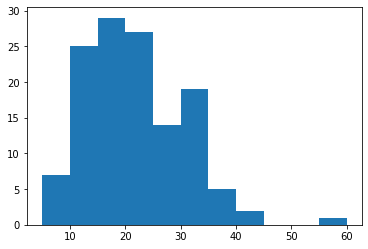

In [11]:
# take a look at the base score distribution
_ = plt.hist(discretized_data.mds_part3_base, bins='auto')

In [12]:
# qauntiles seem appropriate
print(np.quantile(discretized_data.mds_part3_base, .25))
print(np.quantile(discretized_data.mds_part3_base, .50))
print(np.quantile(discretized_data.mds_part3_base, .75))

15.0
20.0
28.0


In [13]:
# discretize on quantiles
discretized_data["mds_part3_base"] = Discretiser(method="fixed", numeric_split_points=[15, 20 , 28]).transform(discretized_data["mds_part3_base"].values)
discretized_data.head()


,typerandomization1_base,typerandomization2_base,mds_part3_base,delta_3m,delta_6m,delta_12m
idnum_base,,,,,,
C002,2.0,8888.0,3,0,0,0
C003,3.0,1.0,3,0,0,0
C005,1.0,8888.0,1,0,1,0
C004,1.0,8888.0,3,2,1,2
C007,2.0,8888.0,3,0,0,0


In [14]:
# check the counts for each base score level
Counter(discretized_data.mds_part3_base)

Counter({3: 33, 1: 29, 2: 35, 0: 32})

The 2 randomization events can be thought of as producing 4 different interventions over the course of the study; only high intensity, only moderate intensity, control and high intensity, and control and moderate intensity. 

Because there are different timepoints, the differences between the control group and the exercise groups can still be modeled, along with the data for the entire 12 months, without an additional node for randomization event 2. The drawback to this approach is that the control group in the first six months will now be modeled as 2 independent control groups. It would probably be better to begin by structuring the model with the additional node for randomization event 2, as this would be easier to interpret. However, I decided to continue with the structure as previously defined and treat the samples as being randomized into 4 different interventions.

In [15]:
discretized_data.loc[discretized_data['typerandomization1_base'] == 1,'experimental_group'] = 1
discretized_data.loc[discretized_data['typerandomization1_base'] == 2,'experimental_group'] = 2
discretized_data.loc[discretized_data['typerandomization2_base'] == 1,'experimental_group'] = 3
discretized_data.loc[discretized_data['typerandomization2_base'] == 2,'experimental_group'] = 4
discretized_data = discretized_data.drop(['typerandomization1_base', 'typerandomization2_base'], axis=1)

discretized_data.head()


,mds_part3_base,delta_3m,delta_6m,delta_12m,experimental_group
idnum_base,,,,,
C002,3,0,0,0,2.0
C003,3,0,0,0,3.0
C005,1,0,1,0,1.0
C004,3,2,1,2,1.0
C007,3,0,0,0,2.0


In [16]:
# add some readability to the discrete numeric values
mds_part3_base_map = {0: "below-15", 
                      1: "between-15-and-20", 
                      2: "between-20-and-28", 
                      3:"above-28"}

experimental_group_map = {1: "high-intensity",
                          2: "mod-intensity",
                          3: "control-and-high",
                          4: "control-and-mod"}

delta_map =  {0: "improvement",
              1: "no-change",
              2: "worsening",
              3: "no-measure"}

discretized_data["mds_part3_base"] = discretized_data["mds_part3_base"].map(mds_part3_base_map)
discretized_data["experimental_group"] = discretized_data["experimental_group"].map(experimental_group_map)
discretized_data["delta_3m"] = discretized_data["delta_3m"].map(delta_map)
discretized_data["delta_6m"] = discretized_data["delta_6m"].map(delta_map)
discretized_data["delta_12m"] = discretized_data["delta_12m"].map(delta_map)

discretized_data.head()


,mds_part3_base,delta_3m,delta_6m,delta_12m,experimental_group
idnum_base,,,,,
C002,above-28,improvement,improvement,improvement,mod-intensity
C003,above-28,improvement,improvement,improvement,control-and-high
C005,between-15-and-20,improvement,no-change,improvement,high-intensity
C004,above-28,worsening,no-change,worsening,high-intensity
C007,above-28,improvement,improvement,improvement,mod-intensity


In [17]:
# check discrete values are ok
data_vals = {col: discretized_data[col].unique() for col in discretized_data.columns}
data_vals

{'mds_part3_base': array(['above-28', 'between-15-and-20', 'between-20-and-28', 'below-15'],
       dtype=object),
 'delta_3m': array(['improvement', 'worsening', 'no-change', 'no-measure'],
       dtype=object),
 'delta_6m': array(['improvement', 'no-change', 'worsening', 'no-measure'],
       dtype=object),
 'delta_12m': array(['improvement', 'worsening', 'no-measure', 'no-change'],
       dtype=object),
 'experimental_group': array(['mod-intensity', 'control-and-high', 'high-intensity',
        'control-and-mod', nan], dtype=object)}

The NaN values in the experimental group column come from individuals who dropout of the study. There is a group of samples that droped out and there is a couple of samples that are control samples that did not drop out and were not assigned an intervention at six months. 

In [18]:
# these are sample not in the defined experimental group
discretized_data[discretized_data.experimental_group.isna()]


,mds_part3_base,delta_3m,delta_6m,delta_12m,experimental_group
idnum_base,,,,,
C028,between-15-and-20,no-measure,no-measure,no-measure,NaN
C032,below-15,no-measure,no-measure,no-measure,NaN
C064,below-15,no-change,no-measure,no-measure,NaN
C080,between-20-and-28,no-measure,no-measure,no-measure,NaN
D005,above-28,no-change,no-change,worsening,NaN
D027,between-20-and-28,no-change,worsening,no-measure,NaN
D028,below-15,no-change,worsening,no-measure,NaN
D039,above-28,no-change,worsening,no-measure,NaN
P013,above-28,no-change,worsening,no-change,NaN


In [19]:
# same samples in raw data
data[data['idnum_base'].isin(discretized_data[discretized_data.experimental_group.isna()].index)]

,idnum_base,typerandomization1_base,typerandomization2_base,mds_part3_base,delta_3m,delta_6m,delta_12m
19,C028,3.0,NaN,19.0,NaN,NaN,NaN
22,C032,3.0,NaN,11.0,NaN,NaN,NaN
49,C064,3.0,NaN,11.0,-3.0,NaN,NaN
61,C080,3.0,NaN,27.0,NaN,NaN,NaN
69,D005,3.0,NaN,29.0,-3.0,3.0,5.0
79,D027,3.0,NaN,20.0,-2.0,5.0,NaN
82,D028,3.0,NaN,14.0,-2.0,9.0,NaN
88,D039,3.0,NaN,28.0,-2.0,4.0,NaN
98,P013,3.0,NaN,28.0,1.0,9.0,0.0
128,P032,3.0,NaN,22.0,30.0,25.0,NaN


There is not enough (n=2) control samples that did not drop out but were not assigned an intervention at six months so these are dropped from the data set.

The remaining samples are controls at the initial randomization but dropped out before the second randomization. Thus, the samples can be included by random assignment to experimental groups 3 and 4 and their drop out will be modelled by the "no-meaure" level.


In [20]:
# drop
discretized_data = discretized_data.drop(discretized_data[(discretized_data.experimental_group.isna()) & (discretized_data['delta_12m'] != 'no-measure')].index)

# random assignment
ids = discretized_data[(discretized_data.experimental_group.isna()) & (discretized_data['delta_12m'] == 'no-measure')].index.tolist()
print("Order before shuffle: ", ids)

# seed to reproduce!
random.Random(42).shuffle(ids)
print("Order after shuffle: ", ids)
ids_g3 = ids[0:round(len(ids) / 2)]
ids_g4 = ids[round(len(ids) / 2)::]
print("Group 3: ", ids_g3)
print("Group 4:", ids_g4)

# do the assignment
discretized_data.loc[ids_g3,'experimental_group'] = "control-and-high"
discretized_data.loc[ids_g4,'experimental_group'] = "control-and-mod"


Order before shuffle:  ['C028', 'C032', 'C064', 'C080', 'D027', 'D028', 'D039', 'P032']
Order after shuffle:  ['C080', 'D027', 'D039', 'P032', 'C064', 'D028', 'C028', 'C032']
Group 3:  ['C080', 'D027', 'D039', 'P032']
Group 4: ['C064', 'D028', 'C028', 'C032']


In [21]:
# check discrete values again
data_vals = {col: discretized_data[col].unique() for col in discretized_data.columns}
data_vals


{'mds_part3_base': array(['above-28', 'between-15-and-20', 'between-20-and-28', 'below-15'],
       dtype=object),
 'delta_3m': array(['improvement', 'worsening', 'no-change', 'no-measure'],
       dtype=object),
 'delta_6m': array(['improvement', 'no-change', 'worsening', 'no-measure'],
       dtype=object),
 'delta_12m': array(['improvement', 'worsening', 'no-measure', 'no-change'],
       dtype=object),
 'experimental_group': array(['mod-intensity', 'control-and-high', 'high-intensity',
        'control-and-mod'], dtype=object)}

The performace of the model can be evaluated with a train test split. One could perform k-fold cross validation to be more precise.

In [22]:

# Split 90% train and 10% test
train, test = train_test_split(discretized_data, train_size=0.9, test_size=0.1, random_state=42)


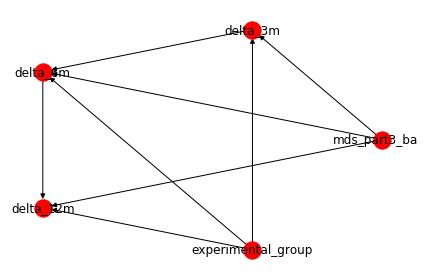

In [23]:
# Need to change the node labels but same structure as before
sm = StructureModel()
sm.add_edges_from([
    ('mds_part3_base', 'delta_3m'),
    ('mds_part3_base','delta_6m'),
    ('mds_part3_base', 'delta_12m'),
    ('experimental_group','delta_3m'),
    ('experimental_group','delta_6m'),
    ('experimental_group', 'delta_12m'),
    ('delta_3m','delta_6m'),
    ('delta_6m','delta_12m')
])
_ = plot_structure(sm)

In [24]:
# fit on all data so nodes can see all possible states
bn = BayesianNetwork(sm)
bn = bn.fit_node_states(discretized_data)

# learn conditional probability of each node
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

/Users/kyle/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/kyle/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [25]:
# we can see how well we are predicting with this model 
classification_report(bn, test, "delta_6m")

/Users/kyle/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision,recall,f1-score,support
delta_6m_improvement,0.500000,0.500000,0.500000,4
delta_6m_no-change,0.571429,0.800000,0.666667,5
delta_6m_no-measure,0.000000,0.000000,0.000000,0
delta_6m_worsening,0.000000,0.000000,0.000000,4
macro avg,0.267857,0.325000,0.291667,13
micro avg,0.461538,0.461538,0.461538,13
weighted avg,0.373626,0.461538,0.410256,13


Judging from the low scores in the classification report, the model is performing poorly when classifying endpoint levels. The model has too many parameters for the number of training samples (parameters > degress of freedom). There are also only 13 samples in the test set. Since there is a small number of samples in the test set, the endpoint level no-measure at 6 months is not observed. Though the recall of no-change at 6 months (0.8) is relatively high, the precision is still low (0.57). 

However, supposing the model was performing well, some insights can be gained by examining
the conditional probability distributions of the nodes.

Normally, to make inferences from the conditional probability distributions, the model should be retrained on the full data set, given the model is performing well. However, I am skipping this step for the sake of brevity.

Next, I compare interventions at 6 months, given that there was improvement at 3 months and a base motor score above 28.

In [26]:
# examining the conditional probabilities at the delta_6m node for the high intensity group 
tmp = bn.cpds["delta_6m"]
idx = pd.IndexSlice
tmp.loc[idx[:], idx['improvement','high-intensity','above-28']]



delta_6m
improvement    0.555556
no-change      0.222222
no-measure     0.111111
worsening      0.111111
Name: (improvement, high-intensity, above-28), dtype: float64

In this model, individuals who show some improvement at 3 months and have a base motor score above 28 have a 55% probability of improvement at 6 months with high intensity exercise. 



In [27]:
# delta_6m for similar individual with different treatments
print(tmp.loc[idx[:], idx['improvement','mod-intensity','above-28']])
print(tmp.loc[idx[:], idx['improvement','control-and-high','above-28']])
print(tmp.loc[idx[:], idx['improvement','control-and-mod','above-28']])

delta_6m
improvement    0.500
no-change      0.250
no-measure     0.125
worsening      0.125
Name: (improvement, mod-intensity, above-28), dtype: float64
delta_6m
improvement    0.4
no-change      0.2
no-measure     0.2
worsening      0.2
Name: (improvement, control-and-high, above-28), dtype: float64
delta_6m
improvement    0.4
no-change      0.2
no-measure     0.2
worsening      0.2
Name: (improvement, control-and-mod, above-28), dtype: float64


Similar indivdiuals with the moderate intensity exercise have a 50% probability of improvement. Similar individuals with no prescribed exercise (both control groups) have a 40% probability of improvement. 

Thus, at 6 months, high intensity exercise gives the best probability of improvement among individuals who have shown improvement after 3 months and have base scores greater than 28. Improvement is defined as less than -3.2 difference from the baseline MDS-UPDRS Motor Examination (ME)- in other words, individuals whose MDS-UPDR ME score decreased more than 3.2 points.

Given the model training is sample limited, a refinement to the model could be made be decreasing the number of discrete levels at each endpoint. For example, insted of:
    
    "improvement, no-change, no-measure, worsening"

A binary classification into:

    "worsening, not-worsening"

or,
    
    "improving, not-improving"
    
May yield better model performance. 
    
One of the key factors missing in the model is the degree to which individuals adhere to their prescribed exercise. This could be incorporated via data from the activity monitor log (aml table).

Another factor that may be important to model performance is a participants adverse events. This data could be investigate using the data in the adverse events (ae) table.*

Additional counterfactuals could be examined by including phenotypic data such as sex, age, and health information (demo, gmh, gmhmed, gmnpdmed, gmpd, mnpd_med tables). One example is usage of PD specific and non-PD specific medication. Maybe, a certain medication is causing the improvement in MDS-UPDRS Motor Examination (ME) scores. 

Other questions we could begin to answer with this model include:
Is high intensity exercise better for individuals with a high or low MDS UPDRS ME base score? What gives a high probability of no-measure at timepoint 12 months given a measure in timepoint 6 months; in other words, what may be causing people to drop out of the study? And conversely, what may be causing people to stick with the study?

If the model is expanded to include an adherence to excercise node, one could perform an intervention with the causalnex InferenceEngine.

In [ ]:
# e.g.
#ie = InferenceEngine(bn)
#ie.do_intervention

Then one could examine the conditional probability of the given endpoint when all individual adhere to their prescribed exercise to the maximum extent.

Lastly, instead of looking at the MDS-UPDRS Motor Examination (ME) scores outcomes, a different outcome like depression as measured by the Beck Depression Index (bdi table) could be used. This may be important to practitioners if it was found that moderate excercise could help with depression in patients with Parkinson's disease (PD), since depression is a symptom of PD.


*It would be interesting to develop a model for factors causing adverse events. 